In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import sys
import cupy as cp

cp.cuda.Device(0).use()
print(f"Usando: {cp.cuda.runtime.getDeviceProperties(0)['name'].decode('utf-8')}")

sys.path.append(os.path.abspath(os.path.join('..')))

from models.utils import train_val_test_split, grid_search_and_update, init_hparams_csv, sweep_and_update, load_hparams_csv
from models.neural_net import NeuralNetwork
from models.constants import *


Usando: NVIDIA GeForce RTX 3070 Ti Laptop GPU


In [15]:
X_images = np.load("../data/X_images.npy ")
X_images = X_images / NORMALIZATION_FACTOR

y_images = np.load("../data/y_images.npy ")

X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(X_images, y_images)

X_train = cp.asarray(X_train)
y_train = cp.asarray(y_train)
X_val = cp.asarray(X_val)
y_val = cp.asarray(y_val)
X_test = cp.asarray(X_test)
y_test = cp.asarray(y_test)

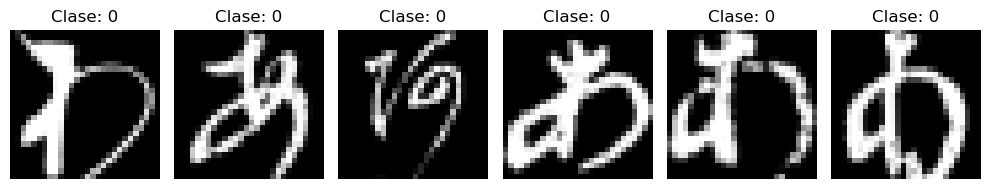

In [16]:
# Visualizar las primeras 3 imágenes del dataset
fig, axes = plt.subplots(1, 6, figsize=(10, 4))

for i in range(6):
    img = X_images[i].reshape(28, 28)  # Reconvertir a matriz 28x28
    axes[i].imshow(img, cmap="gray")
    axes[i].set_title(f"Clase: {y_images[i]}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()


### M0

In [17]:
model = NeuralNetwork(layer_sizes=[IMAGE_SIZE, 100, 80, NUM_CLASSES])

history = model.train(
    X_train, y_train,
    X_val, y_val,
)

Training:  82%|████████████████████████████████████████▎        | 4109/5000 [01:05<00:14, 62.34it/s]


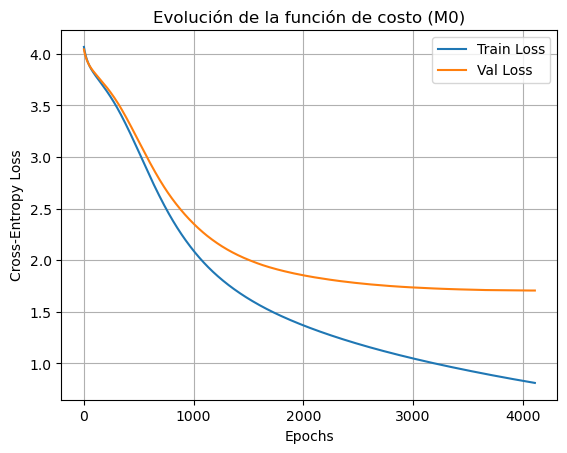

In [18]:
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel("Epochs")
plt.ylabel("Cross-Entropy Loss")
plt.title("Evolución de la función de costo (M0)")
plt.legend()
plt.grid(True)
plt.show()

Train Accuracy: 0.8097
Train Cross-Entropy Loss: 0.8147


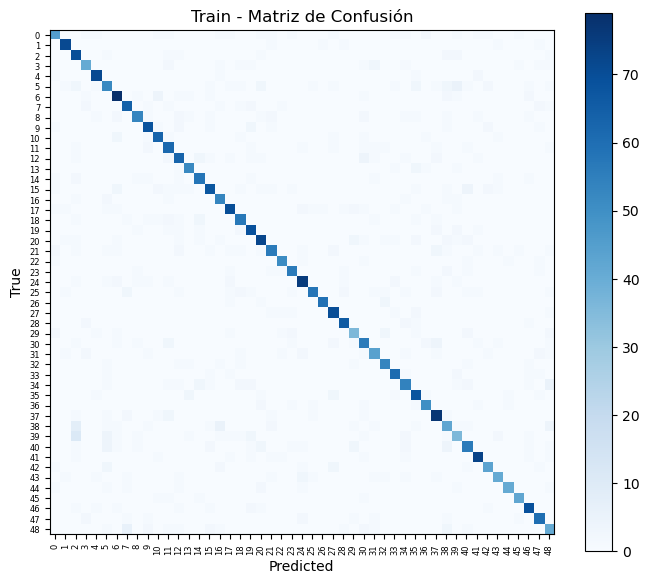

Validation Accuracy: 0.5827
Validation Cross-Entropy Loss: 1.7063


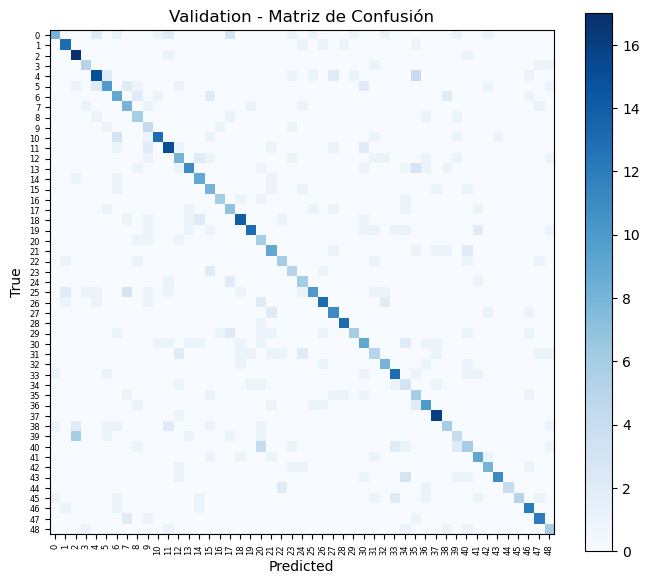

In [19]:
# Evaluación completa en train y validation
model.evaluate_metrics(X_train, y_train, title_prefix="Train")
model.evaluate_metrics(X_val, y_val, title_prefix="Validation")

### M1

In [20]:
init_hparams_csv(HYPERPARAMS_FILE)

Hiperparámetros por defecto guardados en: hparams.csv


In [21]:
architectures = [
    # 1 capa oculta
    (IMAGE_SIZE, 64, NUM_CLASSES),
    (IMAGE_SIZE, 128, NUM_CLASSES),
    (IMAGE_SIZE, 256, NUM_CLASSES),

    # 2 capas ocultas
    (IMAGE_SIZE, 128, 64, NUM_CLASSES),
    (IMAGE_SIZE, 256, 128, NUM_CLASSES),
    (IMAGE_SIZE, 512, 256, NUM_CLASSES),

    # 3 capas ocultas
    (IMAGE_SIZE, 256, 128, 64, NUM_CLASSES),
    (IMAGE_SIZE, 512, 256, 128, NUM_CLASSES),
    (IMAGE_SIZE, 768, 384, 192, NUM_CLASSES),
]

sweep_and_update(
    X_train, y_train, X_val, y_val,
    param_name="layer_sizes",
    values=architectures
)

Sweep layer_sizes: 100%|██████████| 9/9 [21:32<00:00, 143.65s/it]

Actualizado 'layer_sizes' a: (784, 768, 384, 192, 49)
Mejor layer_sizes: (784, 768, 384, 192, 49) con val_loss = 1.5998


In [22]:
sweep_and_update(
    X_train, y_train, X_val, y_val,
    param_name="batch_size",
    values=[None, 512, 256, 128, 64, 32, 16]
)

Sweep batch_size: 100%|██████████| 7/7 [21:09<00:00, 181.30s/it]   

Actualizado 'batch_size' a: 512
Mejor batch_size: 512 con val_loss = 1.5978


In [23]:
sweep_and_update(
    X_train, y_train, X_val, y_val,
    param_name="lr",
    values=[0.1, 0.01, 0.005, 0.001, 0.0005, 0.0001]
)

Sweep lr: 100%|██████████| 6/6 [32:24<00:00, 324.03s/it]

Actualizado 'lr' a: 0.01
Mejor lr: 0.01 con val_loss = 1.5978


In [24]:
param_grid = {
    "use_adam": [True, False],
    "beta1": [0.9, 0.95, 0.99],
    "beta2": [0.99, 0.999, 0.9999]
}

grid_search_and_update(
    X_train, y_train, X_val, y_val,
    param_grid=param_grid,
)

Grid Search: 100%|██████████| 18/18 [07:00<00:00, 23.37s/it]

Actualizado 'use_adam' a: False
Actualizado 'beta1' a: 0.9
Actualizado 'beta2' a: 0.99
Grid Search terminado. Mejor val_loss = 1.5978


In [25]:
sweep_and_update(
    X_train, y_train, X_val, y_val,
    param_name="l2_lambda",
    values=[0.0, 1e-5, 1e-4, 1e-3, 1e-2]
)

Sweep l2_lambda: 100%|██████████| 5/5 [04:32<00:00, 54.50s/it]

Actualizado 'l2_lambda' a: 0.01
Mejor l2_lambda: 0.01 con val_loss = 1.5167


In [26]:
sweep_and_update(
    X_train, y_train, X_val, y_val,
    param_name="dropout_rate",
    values=[0.0, 0.1, 0.2, 0.3, 0.5]
)

Sweep dropout_rate: 100%|██████████| 5/5 [02:45<00:00, 33.00s/it]

Actualizado 'dropout_rate' a: 0.0
Mejor dropout_rate: 0.0 con val_loss = 1.5167


In [27]:
param_grid = {
    "scheduler_type": ["linear", "exponential", None],
    "final_lr": [0.0001, 0.00005]
}

grid_search_and_update(
    X_train, y_train, X_val, y_val,
    param_grid=param_grid,
)

Grid Search: 100%|██████████| 6/6 [09:35<00:00, 95.87s/it]

Actualizado 'scheduler_type' a: None
Actualizado 'final_lr' a: 0.0001
Grid Search terminado. Mejor val_loss = 1.5167


In [28]:
sweep_and_update(
    X_train, y_train, X_val, y_val,
    param_name="use_batchnorm",
    values=[True, False],
    csv_path="hparams.csv",
    metric="val_loss"
)

Sweep use_batchnorm: 100%|██████████| 2/2 [01:56<00:00, 58.04s/it]

Actualizado 'use_batchnorm' a: False
Mejor use_batchnorm: False con val_loss = 1.5167


In [29]:
best_params = load_hparams_csv("hparams.csv")

M1 = NeuralNetwork(
    layer_sizes=best_params["layer_sizes"],
    use_batchnorm=best_params["use_batchnorm"],
    dropout_rate=best_params["dropout_rate"],
    use_adam=best_params["use_adam"],
    beta1=best_params["beta1"],
    beta2=best_params["beta2"],
    eps=1e-8,
    l2_lambda=best_params["l2_lambda"],
    scheduler_type=best_params["scheduler_type"],
    final_lr=best_params["final_lr"],
    seed=RANDOM_SEED
)

M1_history = M1.train(
    X_train, y_train,
    X_val, y_val,
    lr=best_params["lr"],
    final_lr=best_params["final_lr"],
    epochs=best_params["epochs"],
    batch_size=best_params["batch_size"],
    early_stopping=best_params["early_stopping"],
    patience=best_params["patience"],
    show_progress=True
)

Training:  14%|██████▊                                           | 687/5000 [01:35<10:01,  7.17it/s]


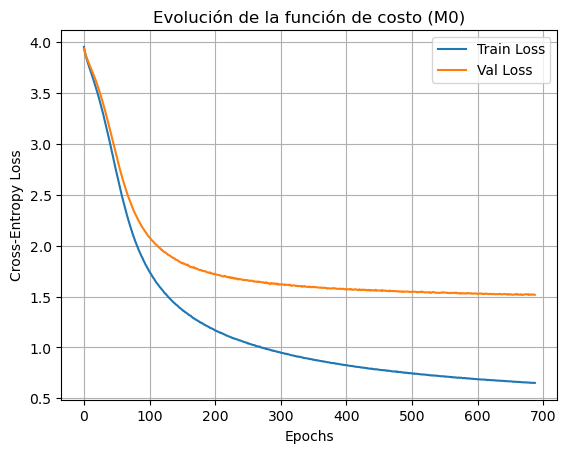

In [30]:
plt.plot(M1_history['train_loss'], label='Train Loss')
plt.plot(M1_history['val_loss'], label='Val Loss')
plt.xlabel("Epochs")
plt.ylabel("Cross-Entropy Loss")
plt.title("Evolución de la función de costo (M0)")
plt.legend()
plt.grid(True)
plt.show()

Train Accuracy: 0.8871
Train Cross-Entropy Loss: 0.6536


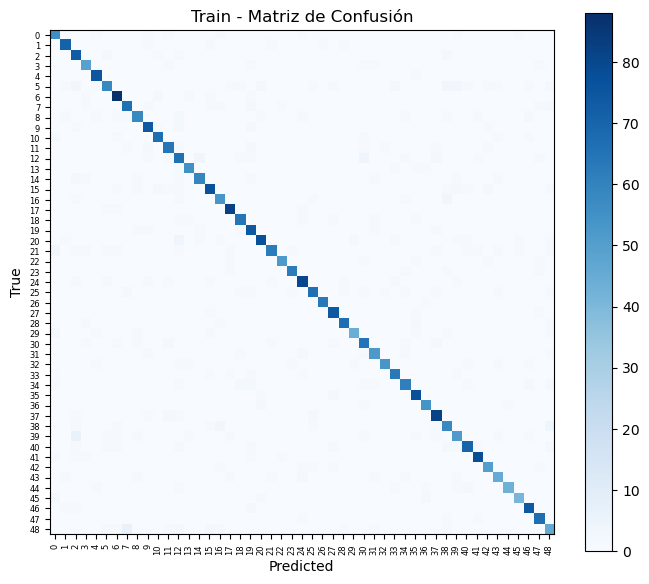

Validation Accuracy: 0.6333
Validation Cross-Entropy Loss: 1.5142


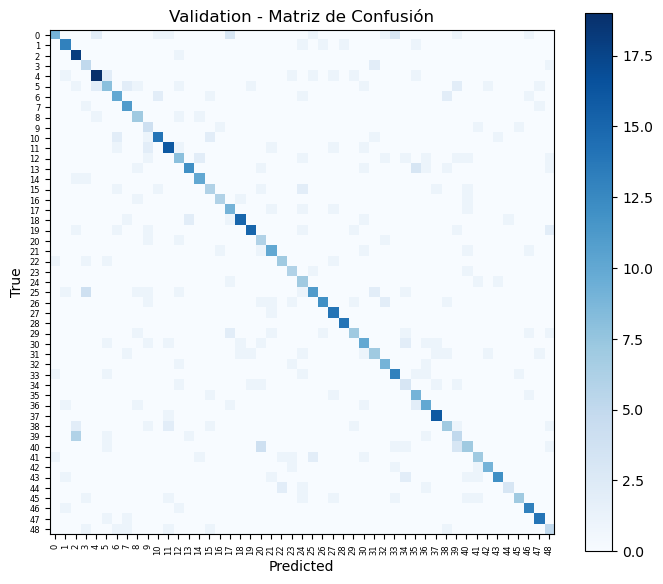

In [31]:
M1.evaluate_metrics(X_train, y_train, title_prefix="Train")
M1.evaluate_metrics(X_val, y_val, title_prefix="Validation")